# Text Classification using LSTM

TensorFlow function `LSTM` provides the 'recurrent' looping within the hidden layers of a neural network, while addressing the vanishing gradient problem at the same time. You can use this RNN to classify large text documents. Since you are dealing with word sequences, you need to create an embedding layer to set up the **T x D** array as input to the RNN layer.

The important variables to remember are:

    V vocabulary size of corpus
    N number of samples
    T sequence length
    D number of input features
    M number of hidden neurons
    K number of neurons in outer dense layer

The dataset has been taken from BBC News archives, with 2,225 articles related to business, entertainment, politics, sports and technology.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
df = pd.read_csv('data/bbc_text_cls.csv')

In [4]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [5]:
# Convert labels to integers in new column

df['targets'] = df['labels'].astype("category").cat.codes

In [6]:
df.head()

,text,labels,targets
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,0
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,0
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,0
3,High fuel prices hit BA's profits\n\nBritish A...,business,0
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,0


In [7]:
# 2,225 documents

df.shape

(2225, 3)

In [8]:
# Note number of classes

K = df['targets'].max() + 1

K

5

In [9]:
# Train-test split data

df_train, df_test = train_test_split(df, test_size=0.3)

In [10]:
print("Number of training samples (N):", df_train.shape[0])

Number of training samples (N): 1557


## Tokenize text data

Use the TensorFlow `Tokenizer` function to convert text documents to sequences of integers. This also generates mapping dictionaries, from which you can find the true vocabulary size (**V**), i.e. all the words, not just the 2000 words reserved for the tokenizer. The **V** variable is used as input size for the embedding layer of the LSTM neural network.

After transforming the text data to sequences of integers, you can access the maximum sequence length by 'padding' the tokenized vectors (with `pad_sequences` function). The sequence length (**T**) matches the number of columns in tokenized training data, i.e. the longest document.

In [11]:
# Set tokenizer vocab 
MAX_VOCAB_SIZE = 2000

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

# Train tokenizer
tokenizer.fit_on_texts(df_train['text'])

In [12]:
# Transform text data

sequences_train = tokenizer.texts_to_sequences(df_train['text'])

sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [13]:
# Obtain word-to-index mapping from tokenizer

word2idx = tokenizer.word_index

V = len(word2idx)

In [14]:
print('True vocabulary size is %s unique tokens' % V)

True vocabulary size is 27785 unique tokens


In [15]:
# Pad sequences so that we get a N x T matrix (documents by max sequence length)

data_train = pad_sequences(sequences_train)

print('Shape of data train tensor:', data_train.shape)
print('Max sequence length:', data_train.shape[1])

Shape of data train tensor: (1557, 2820)
Max sequence length: 2820


In [16]:
# Get sequence length (T) from training data, i.e. maximum sequence length

T = data_train.shape[1]

T

2820

In [17]:
data_test = pad_sequences(sequences_test, maxlen=T)

print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (668, 2820)


**You impose the same sequence length on the test data because in the real world, you would not know the true sequence length so you assume based on the training data.**

## Build the model

As with CNN models, RNNs work with **word embeddings** before entering the recurrent hidden states so you need to implement an embedding layer. The embedding dimensionality is a hyperparameter, which you can modify to improve results. Essentially, it is the recommended length of the word vector in the embedding matrix.

Since this is a many-to-many classification, you need to include **Global Max Pooling** before the outer layer.

NOTE: You actually want the size of the embedding matrix to be **(V + 1) x D**, because the first index starts from 1 and not 0. If the final index of the embedding matrix is V, then it actually has the size V + 1.


In [18]:
# Embedding dimensionality

D = 20

In [19]:
# Input training data of T length (sequence length by features)
i = Input(shape=(T,))

# Embedding matrix V x D (vocab size by embedding dimensions)
x = Embedding(V + 1, D)(i)

# Output is T x M (sequence length by features)
x = LSTM(32, return_sequences=True)(x)

# Flatten for outer layer
x = GlobalMaxPooling1D()(x)

# Output is T x K (sequence length by output nodes)
x = Dense(K)(x)

model = Model(i, x)

**EXERCISE:** You can try other models to improve results:

**1) Multiple LSTM layers**

**2) GRU instead of LSTM**

**3) SimpleRNN instead of LSTM**

**4) `return_sequences=False`, and no global max pooling, i.e. keep final hidden state only**

**5) For hidden layers, try different numbers of hidden units**

**6) Different combinations of all the above**

**Common FAQ:** "How can I choose the best combination of hyperparameters?" Unfortunately, testing with the above options is the solution - there is no shortcut!

In [20]:
# Compile model

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [21]:
# Fit model (takes approx 1 hr)

print('Training model...')

r = model.fit(data_train, 
              df_train['targets'], 
              epochs=50, 
              validation_data=(data_test, df_test['targets']))

Training model...
Epoch 1/50
49/49 [==============================] - 118s 2s/step - loss: 1.5991 - accuracy: 0.3198 - val_loss: 1.5755 - val_accuracy: 0.4686
Epoch 2/50
49/49 [==============================] - 114s 2s/step - loss: 1.5431 - accuracy: 0.3963 - val_loss: 1.4514 - val_accuracy: 0.4925
Epoch 3/50
49/49 [==============================] - 115s 2s/step - loss: 1.2609 - accuracy: 0.4945 - val_loss: 1.0946 - val_accuracy: 0.5374
Epoch 4/50
49/49 [==============================] - 114s 2s/step - loss: 0.9502 - accuracy: 0.6127 - val_loss: 0.8019 - val_accuracy: 0.6347
Epoch 5/50
49/49 [==============================] - 114s 2s/step - loss: 0.6611 - accuracy: 0.7604 - val_loss: 0.9921 - val_accuracy: 0.7290
Epoch 6/50
49/49 [==============================] - 873s 18s/step - loss: 0.5953 - accuracy: 0.8292 - val_loss: 0.6713 - val_accuracy: 0.7695
Epoch 7/50
49/49 [==============================] - 69s 1s/step - loss: 0.5622 - accuracy: 0.8073 - val_loss: 0.5253 - val_accuracy: 0.

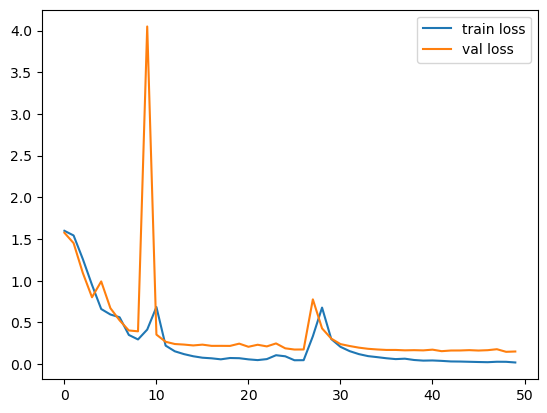

In [22]:
# Plot loss per epoch

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

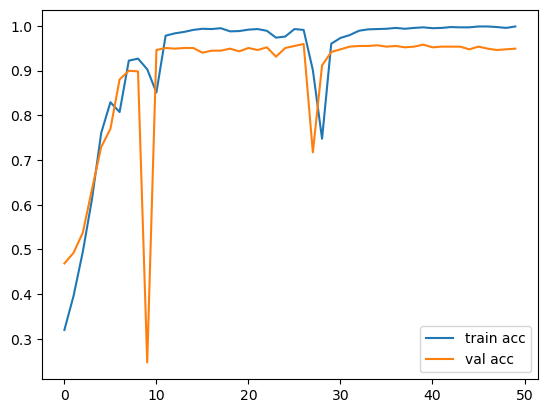

In [23]:
# Plot accuracy per epoch

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

**As expected, the performance on the training set is better than the test set, but with a huge spike in test losses. Training an LSTM model appears more erratic than training CNN model, but this is normal when models get more complex. The losses (and accuracy) are less robust due to different weights and hyperparameters.**


## Run performance metrics

Since the target classes in the dataset are quite well-balanced, F1-score and confusion matrix is usually sufficient to measure the model's performance. You need to generate the predictions through the trained model off the test set, which outputs probability logits per class, rather than allocating a single class to each instance. To compare the predicted labels with the actual labels, you need to create a new object listing the class with highest probability for each instance.

NOTE: To run AUC metric, there is no need to isolate the classes with highest probability - you can use the output probability logits directly in SciKit-Learn function.

In [24]:
from sklearn.metrics import confusion_matrix, f1_score

In [25]:
predictions = model.predict(data_test)

21/21 [==============================] - 5s 208ms/step


In [26]:
type(predictions)

numpy.ndarray

In [27]:
# Note that predicted class is positive, as well as being the highest value

predictions[0]

array([-2.347466 , -2.5148504,  4.1896377, -5.2745347, -2.962849 ],
      dtype=float32)

In [28]:
# Isolate class with highest probability per instance

class_preds = []

for pred in predictions:
    target = pred.argmax()
    class_preds.append(target)


In [30]:
print("Test F1 score:", f1_score(df_test['targets'], class_preds, average='macro'))

Test F1 score: 0.9476050362246866


In [31]:
cm = confusion_matrix(df_test['targets'], class_preds)

In [34]:
import seaborn as sns

def plot_cm(cm):
    classes = ['business', 'entertainment', 'politics', 'sport', 'tech'] 
    df_cm = pd.DataFrame(cm, index=classes, columns=classes) 
    ax = sns.heatmap(df_cm, annot=True, fmt='g') 
    ax.set_xlabel("Predicted") 
    ax.set_ylabel("Target")


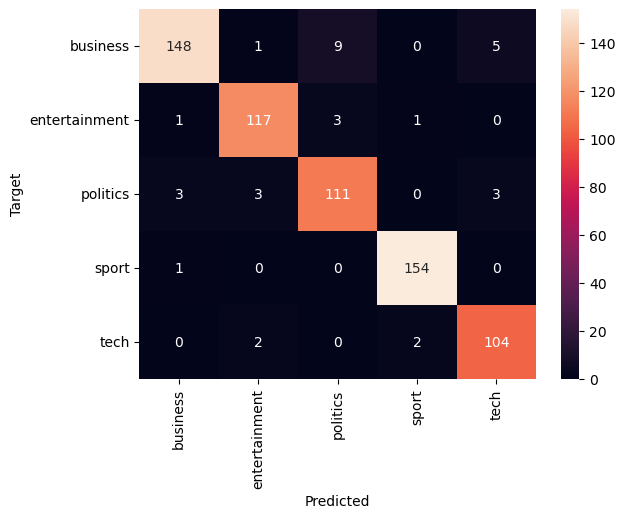

In [35]:
plot_cm(cm)

In [ ]:
# Model has performed very well with LSTM